<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


ERROR! Session/line number was not unique in database. History logging moved to new session 61


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv"

#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/
#csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,122031,180249
34,NJ,37505,44661
24,MI,15718,30030
5,CA,13438,103095
20,LA,13010,47315
21,MA,12500,59437
10,FL,12151,101253
41,PA,11510,66261
16,IL,11256,47727
52,WA,7591,80327


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [8]:
dfUSAPos[-7:]

,date,positive,PCT
26,2020-03-30,160530,0.483076
27,2020-03-31,184683,0.555759
28,2020-04-01,210816,0.634399
29,2020-04-02,239099,0.719510
30,2020-04-03,271988,0.818482
31,2020-04-04,305755,0.920095
32,2020-04-05,332308,1.000000


In [9]:
dfCAPos[-7:]

,date,positive,PCT
26,2020-03-30,6447,0.479759
27,2020-03-31,7482,0.556779
28,2020-04-01,8155,0.606861
29,2020-04-02,9191,0.683956
30,2020-04-03,10701,0.796324
31,2020-04-04,12026,0.894925
32,2020-04-05,13438,1.000000


In [10]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-01,210816,939190,59669,16223.0,31142.0,3837.0,4270.0,71.0,676.0,7084.0,4700,31142.0,1209675,1150006,1150006,954.0,4482.0,74989.0,26133.0,101122.0
2020-04-02,239099,1028649,62101,17157.0,32649.0,4264.0,541.0,67.0,661.0,8586.0,5784,32649.0,1329849,1267748,1267748,1084.0,4335.0,89459.0,28283.0,117742.0
2020-04-03,271988,1124874,61980,19926.0,35991.0,4686.0,593.0,70.0,728.0,10422.0,6962,35991.0,1458842,1396862,1396862,1178.0,3509.0,96225.0,32889.0,129114.0
2020-04-04,305755,1318052,15573,22158.0,38402.0,5207.0,691.0,656.0,154.0,12784.0,8314,38402.0,1639380,1623807,1623807,1352.0,4404.0,193178.0,33767.0,226945.0
2020-04-05,332308,1429724,17307,23061.0,41372.0,5497.0,913.0,612.0,193.0,14486.0,9498,41372.0,1779339,1762032,1762032,1184.0,3322.0,111672.0,26553.0,138225.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-01,8155,21772,57400,1855.0,1855.0,774.0,774.0,0.0,0.0,0.0,171,1855.0,87327,29927,29927,18.0,238.0,0.0,673.0,673.0
2020-04-02,9191,23809,59500,1922.0,0.0,816.0,0.0,0.0,0.0,0.0,203,0.0,92500,33000,33000,32.0,0.0,2037.0,1036.0,3073.0
2020-04-03,10701,24599,59500,2188.0,0.0,901.0,0.0,0.0,0.0,0.0,237,0.0,94800,35300,35300,34.0,0.0,790.0,1510.0,2300.0
2020-04-04,12026,101674,13000,2300.0,0.0,1008.0,0.0,0.0,0.0,0.0,276,0.0,126700,113700,113700,39.0,0.0,77075.0,1325.0,78400.0
2020-04-05,13438,103095,15000,2398.0,0.0,1040.0,0.0,0.0,0.0,0.0,319,0.0,131533,116533,116533,43.0,0.0,1421.0,1412.0,2833.0


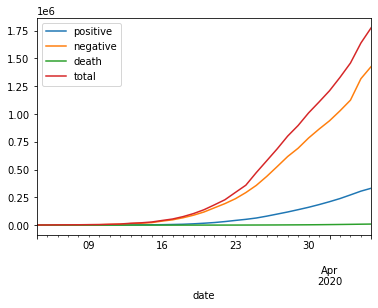

In [12]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [13]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-03-23,31573,402
2020-03-24,42164,471
2020-03-25,51914,673
2020-03-26,63570,884
2020-03-27,68334,991
2020-03-28,85228,1243
2020-03-29,103321,1668
2020-03-30,122653,2112
2020-03-31,140640,2398


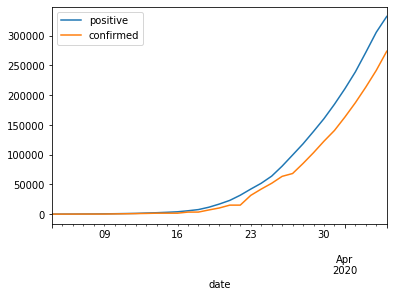

In [14]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [15]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-03-30,6447,20549,64400,1432.0,1432.0,597.0,597.0,0.0,0.0,0.0,133,1432.0,91396,26996,26996,10.0,398.0,0.0,739.0,739.0
2020-03-31,7482,21772,57400,1617.0,1617.0,657.0,657.0,0.0,0.0,0.0,153,1617.0,86654,29254,29254,20.0,185.0,1223.0,1035.0,2258.0
2020-04-01,8155,21772,57400,1855.0,1855.0,774.0,774.0,0.0,0.0,0.0,171,1855.0,87327,29927,29927,18.0,238.0,0.0,673.0,673.0
2020-04-02,9191,23809,59500,1922.0,0.0,816.0,0.0,0.0,0.0,0.0,203,0.0,92500,33000,33000,32.0,0.0,2037.0,1036.0,3073.0
2020-04-03,10701,24599,59500,2188.0,0.0,901.0,0.0,0.0,0.0,0.0,237,0.0,94800,35300,35300,34.0,0.0,790.0,1510.0,2300.0
2020-04-04,12026,101674,13000,2300.0,0.0,1008.0,0.0,0.0,0.0,0.0,276,0.0,126700,113700,113700,39.0,0.0,77075.0,1325.0,78400.0
2020-04-05,13438,103095,15000,2398.0,0.0,1040.0,0.0,0.0,0.0,0.0,319,0.0,131533,116533,116533,43.0,0.0,1421.0,1412.0,2833.0


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    308850
dead           8407
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    12837
dead           289
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                308850
Spain             126168
Italy             124632
Germany            96092
France             90848
China              82543
Iran               55743
United Kingdom     42477
Turkey             23934
Switzerland        20505
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [24]:
dfState.loc['FL'].head(7)

,date,positive,current_total,pct
state,,,,
FL,2020-04-05,12151,12151,1.000000
FL,2020-04-04,11111,12151,0.914410
FL,2020-04-03,9585,12151,0.788824
FL,2020-04-02,8010,12151,0.659205
FL,2020-04-01,6955,12151,0.572381
FL,2020-03-31,6338,12151,0.521603
FL,2020-03-30,5473,12151,0.450416


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

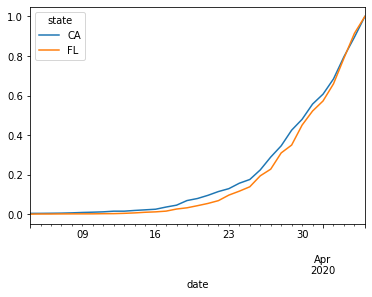

In [26]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

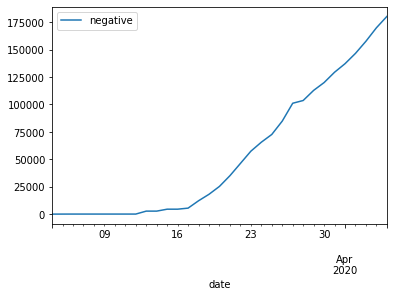

In [28]:
x = dfNYTesting.plot.line()

In [29]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,current_total,pct
304,FL,2020-04-05,12151,12151,1.000000
305,FL,2020-04-04,11111,12151,0.914410
306,FL,2020-04-03,9585,12151,0.788824
307,FL,2020-04-02,8010,12151,0.659205
308,FL,2020-04-01,6955,12151,0.572381
309,FL,2020-03-31,6338,12151,0.521603
310,FL,2020-03-30,5473,12151,0.450416
311,FL,2020-03-29,4246,12151,0.349436
312,FL,2020-03-28,3763,12151,0.309686
313,FL,2020-03-27,2765,12151,0.227553


In [30]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .66)].sort_values(by='positive',ascending=False)


,state,date,positive,current_total,pct
307,FL,2020-04-02,8010,12151,0.659205
1261,PA,2020-04-02,7016,11510,0.609557
674,MD,2020-04-02,2331,3609,0.645885
1501,VA,2020-04-02,1706,2637,0.646947
455,ID,2020-04-02,669,1077,0.621170
244,DC,2020-04-02,653,998,0.654309
276,DE,2020-04-02,393,673,0.583952


In [31]:
datecutoff

Timestamp('2020-04-02 00:00:00')

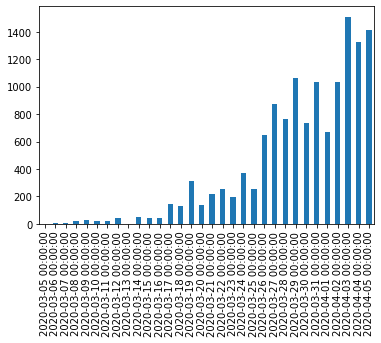

In [32]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [35]:
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")

positive     332308
negative    1429724
pending       17307
death          9498
total       1779339
dtype: int64
Current Infection Rate 18.675924%
Percentage of US affected: 0.104133%


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfState = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfState['ABBR']=dfState.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfState = dfState.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfState.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfState)

In [46]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.negative / dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T

,state_pos_pop,state_test_pop
state,,
AK,0.025289,0.833715
AL,0.036629,0.230095
AR,0.027503,0.345019
AS,NaN,NaN
AZ,0.031173,0.345404
CA,0.034010,0.260919
CO,0.079271,0.335751
CT,0.159174,0.493509
DC,0.141410,0.826923
